# Markov Chain Monte Carlo - Part 1

In this blog series I would like to investigate Markov Chain Monte Carlo (MCMC) methods for sampling, density estimation and optimisation that are common in computational science. The theory of Markov chains has close ties to graph theory and is very common when talking about processes on networks. 

In this introductory post we will tackle Bayseian inference sampling that will motivate the requirement for Markov methods as well as talking about the Metropolis-Hastings algorithm.  

When we have a dataset, $\{x^i\}$ we often wish to create a *mathematical model* to describe what is going on, allowing us to make predictions about other scenarios not contained within the dataset. In order to do this we should want to fit the parameters of our model, $\{\theta_j\}$, to the dataset. It happens that what we *really* desire is the *posterior probability distribution*, $P(\theta \mid x)$ which contains everything we want to know about our model.  

Abstracting this we find the **sampling problem**. Given a dataset $x_i\in X$ generated by a probability density $\pi(x)$ for a distribution $D$ over a finite set $X$, we wish to find an efficient randomized algorithm which outputs an element of $x\in X$ with a probability of approximately $\pi(x)$. More generally, we wish to output a sample of elements from $X$ drawn according to $\pi(x)$. Unfortunately we do not have any knowledge of $\pi(x)$ but *do* have the points in the dataset. This allows us to estimate on the set $f:X\rightarrow \mathbb R$ as well as infer many other properties. 


## Bayesian inference


**Bayes theorem** states the posterior probability of a model's parameter $\theta$ given some data point $x$ can be decomposed as consisting of a *prior* parameter distribution $P(\theta)$ (our estimate before training on any data) multiplied by the likelyhood of obtaining $x$ given the parameter is set at $\theta$, namely $P(x\mid \theta)$. 


$$
P(\theta\mid x) = \frac{P(x\mid \theta)P(\theta)}{\int _{\mathbb R} P(x\mid \theta )P(\theta)d\theta }
$$

But the important part is,

$$
P(\theta \mid x) \propto P(x\mid \theta)P(\theta)
$$

We can then go on to compute *expectation values*, $E$, for some function $f(\theta)$ by integrating the posterior distribution over the parameter space $\Theta$. 

$$
E[f(\theta)] = \int_\Theta d\theta f(\theta) P(\theta\mid x)
$$

In fact all statistical tests or questions we could ever want regarding our model involve computing expectation values at some point, this is because $d\theta  P(\theta\mid x)$ is a *Lebesgue measure* for the parametrisation $\theta$ of the model to probabilities on the real interval $[0,1]$. The expectation values themselves are paramatrisation independent. 

$$
E[f(\theta)] = E[f(\theta')]
$$

It seems that we have successfully generated a model of our dataset and can probe any quantity we like by constructing the posterior distribution. *Unfortunately *, integrating this expression is non-trivial analytically, in fact it is the main stumbling block for such inference methods.


## Approximating the posterior integral 

In order to approximate this integral we are going to use a **Markov chain** that has a *unique*, *stationary* equilibrium distribution (more on that later). A Markov chain is a sequence of points in the parameter space whose next state depends only on the current state and not the chain history. In other words the states in the Markov chain are samples form the distribution that allow us to build a picture of the density. The update from point $\theta$ to point $\theta'$ is found by applying a *transition kernel*, $T(\theta'\mid \theta)$, to the proposed point. For all the points in the neighbourhood, then this defines a transition *density*, where a high denisty indicates a high probability of transitioning from $\theta\rightarrow \theta'$. In general the density at the new state is different from the denisty at the initial state every time we tweak the parameters.

$$
P'(\theta) =\int d\theta' P(\theta') T(\theta'\mid \theta)
$$

If the transition kernel is chosen such that its application on the posterior $P(\theta\mid x)$ leads to the *same* distribution then we say that the transition operator *preserves* the distribution for all $\theta\in \mathbb R$. 

$$
P(\theta\mid x) = \int d\theta'  P(\theta'\mid x)T(\theta'\mid \theta)
$$

In other words a set of samples from the posterior will transition into a new set of samples that are distributed *according to the posterior*, this need not be the general case as we expect an arbitrary transition operator to yield a *new* distribution of samples. 

By considering the measure $d\theta P(\theta\mid x)$, contributions to the integral depend both on the *volume* in the parameter space $d\theta$ and the value of the probability denisty at that point $P(\theta\mid x)$. Therefore there are different regions of the parameter space that will dominate the contribution to the expectation value. In fact the two contributions are often in opposition to each other, the region around the mean will have a high density but a small volume; while the tails of a distribution have a high volume but low density. It happens that the most significant contribution to the integral, where the measure is concentrated, is from the region *between* these extremes. If we identify this region and sample from it then the integral can be accurately computed with far less computational resorce than simply sampling the whole space. Further, the sampling of regions *outisde* of the concentrated zone is wasted as it consists of biased, unrepresentative samples. 

If the Markov chain preserves the posterior distribution as it transitions from state to state, then no matter where it starts it will head towards the region of maximal contribution to the integral. This behaviour is due to the ergodicity of the chain. Over time the $N$ samples $\{\theta_0, \theta_1, \dots ,\theta_N\}$ generated by the chain build a picture of the region of importance. We then simply average the target function over the chain to obtain the Markov estimate $f_N$. 

$$
f_N = \frac 1 N \sum^N_{i=0} f(\theta_i)
$$

After enough time has progressed this asymptotically reproduces the expectation value. 

$$
\lim _{N \rightarrow \infty} f_N = E[f]
$$

Again however this is too computationally expensive to perform depending on the convergence rates. The finite behaviour of the exploration can be decomposed into three distinct phases due to the central limit theorem: 

* the journey from the initial starting point of the Markov chain in the parameter space to the region of interest. This is characterised by a particle filter (more on this in another post) that essentially applies the transition operator until a stationary distribution is obtained. It is known as the 'burn-in' phase.

$$
P(\theta\mid x) = \int d\theta T(\theta, \theta')P(\theta'\mid x) \dots \int d\theta T(\theta''', \theta'''')P(\theta''''\mid x)
$$

During the burn-in phase the MCMC-estimates $f_N$ are highly biased. 

* the first steps in the region of interest. This is characterised by the stationary distribution under the transition operator. 

* a long refining exploration following the initial period in the region. In some cases we can throw away the initial sampling generated by the chain to remove any bias from the starting position, retaining only the more representative samples from the region of interest. 

If the chain ergodicity breaks down then the exploration might deviate from this idealised behaviour and might not investigate the region of interest as well as we hope. We can however cross validate our model using a *posterior predictive chack* (PPC). Essentially this means simulating data using the fitted model and comparing it to the observed data points. We can agian use the posterior distribution to compute the probability of the simulated data. 

$$
P(x'\mid x) = \int d \theta P(x'\mid \theta) P(\theta\mid x)
$$

Cross validation allows us to quantify discrepancies between the simulated data and the observed set. This is why in some scenarios the original dataset should partitioned by drawing random samples into a training and a testing set so that we do not test the model against exactly the same set that it trained on. 

## So how does the transition kernel focus the chain?

The Markov transition kernel $T(\theta'\mid\theta)$ is a conditional probability distribution that generates the Markov process. This means that the sequence of samples drawn from the posterior distribution are *correlated*. The distribution-preserving property of the transition kernel between succesive states is an important aspect in deploying the central limit theorem for our Markov chain. In fact it is exactly this property that causes the asymptotic convergence of the Markov estimate to the expectation value in finite time. 

There are a number of methods in place that generate this invariant property for a Markov kernel, but the most commonly used is the **Metropolis-Hastings** algorithm (MH). The MH transition consists of a stochastic update in the parameters to a new proposal state. The algorithm checks before accepting the new update that it has not strayed too far from the region of interest of the posterior distribution; if it has the proposed state is rejected and a new state is proposed. This is the key step that moves the Markov chain towards our region of interest instead of performing a wasteful sampling. The acceptance probability of an update is then:

$$
A(\theta'\mid \theta) = \min \bigg( 1,\frac{P(\theta'\mid x)}{P(\theta\mid x)}\frac{Q(\theta'\mid \theta)}{Q(\theta\mid \theta')}\bigg)
$$

Here $Q$ is the *candidate generating kernel* that describes the probability density for the proposed state $\theta'$ given the starting state $\theta$. It is this distribution from which the proposal state is drawn. The *actual* candidate state is then accepted with probability $\alpha(\theta'\mid \theta)$,

$$
\alpha (\theta'\mid \theta) = \int A(\theta'\mid \theta) Q(\theta'\mid\theta) d\theta',
$$

otherwise it is rejected with probability $1- \alpha(\theta'\mid \theta)$ and the process remains in state $\theta$. 


Earlier we remarked that our Markov chain must have a *unique*, *stationary* equilibrium distribution. Let's explore exactly what that infers for our chain. Uniqueness means that there are no other measurable distributions $P'(\theta\mid x)$ that coincide with our posterior distribution $P(\theta\mid x)$ we wish to sample. The stationarity property indicates that the distribution does not change in time during the process. These two properties are satisfied if:

* the chain is *reversible* meaning that the probability of transitioning from state $\theta$ to $\theta'$ is symmetric,

* the chain is *ergodic* over the parameter space meaning that it is *recurrent* yet *aperiodic*. This means that the chain has a finite probability of returning to a visited state yet there is no fixed interval or recurring number of steps that this will occur in. 

Under these assumptions iterations of the transition kernel will converge to an invariant distribution. 

If the state transition function is symmetric then $Q(\theta'\mid \theta) = Q(\theta\mid \theta')$ and hence this can be canceled in the acceptance probability. Hence while the algorithm will propagate to regions of larger volume, the rejection factor concentrates to the regions of high denisty. The result of these two opposing procedures forces the Markov chain to explore regions of concentrated measure. 

To complete the construction of the transition kernel in terms of $A(\theta'\mid \theta)$ we must consider the potentially finite probability of remaining at state $\theta$ in addition to the probability of transitioning to $\theta'$. 

$$
T(\theta'\mid\theta) = Q(\theta'\mid\theta)A(\theta'\mid \theta ) + [1 -  \alpha(\theta'\mid \theta )]   \delta _{\theta} d\theta'
$$

Here the *Dirac measure*, $\delta _{\theta} d\theta'$ is 1 if $\theta\in d\theta'$ and 0 otherwise. Deriving the rejection probability in closed form is often easier said than done and in some cases cannot be achieved, of course that does not mean we can't implement the algorithm computationally! 


## Sampling vs Optimisation

In the above sections we have introduced MCMC in conjunction with the MH transition algorithm as a sampling technique. We recall that the Markov chain will converge into the region where the Lebesgue measure is most concentrated and will hence build a good estimate of the expectation value for a function on the trained model after the burn-in time is completed. We further recall that the MH algorithm is a method for constructing the Markov kernel $T(\theta'\mid \theta)$ with an invariant posterior distribution such that the central limit theorem holds and the sampling converges to the concentrated  region. 

So far we have only discussed MCMC for sampling procedures, however MCMC is extremely useful for *optimisation* too! We will discuss this another time in a future blog post, for now check out the post on simulated annealing! 


## References 

* Chib, S. and E. Greenberg (1995): “Understanding the Metropolis Hastings Algorithm,” American Statistical Journal, 49, 327–335.


* Hastings, W.K. (1970): “Monte Carlo Sampling Methods Using Markov Chains and Their Applications,” Biometrika, 57, 97–109.


* Metropolis, N., A.W. Rosenbluth, M.N. Rosenbluth, A.H. Teller, and E. Teller (1953): “Equations of State Calculations by Fast Computing Machines,” Journal of Chemical Physics, 21, 1087–1092.

# An example

Now that we have some of the theory of MCMC under our belt we can have a quick look at how to implement the Metropolis-Hastings algorithm to sample a distribution. We will start by creating a multivariate normal distribution as our target distribution. 

We will then write a Metropolis-Hastings sampler that draws samples from our target distribution generating a Markov chain. These samples are then visualised and a density plot is created from the sampled points using kernel density estimation (which we talked about in an earlier post). 

In order to see how the Markov chain heads towards the region of concentrated measure we will start the process some distance out. 

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.stats as st
import pandas

In [2]:
def ptarget(x, y):
    '''the distribution we wish to sample'''
    return st.multivariate_normal.pdf([x, y], mean=mean, cov=var)

In [3]:
def metropolis_hastings(p, n = 500):
    '''Samples p, the target distribution, n times according to 
    the Metropolis-Hastings algorithm'''
    
    x = -5.0 # x starting point 
    y = -5.0 # y starting point 
    
    a = 0
    
    samples = np.zeros((n, 2)) # list of samples to fill

    for i in range(n):
        
        # propose new parameters from current state by sampling Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(size=2)
        
        # Metropolis-Hastings condition
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star
            
            a += 1 # number of accepted moves
            
        # update samples list
        samples[i] = np.array([x, y])

    return samples

In [4]:
# set mean and covariance of the target distribution
mean = np.array([0, 1])
var = np.array([[1, .25], [.25, 1]])

# generate the samples
samples = metropolis_hastings(ptarget, 5000)

The *trace* of a parameter plots its value over the course of the sampling. This is often useful for visualising convergence and the mixing of the parameter. It also allows us to estimate the burn-in phase. 

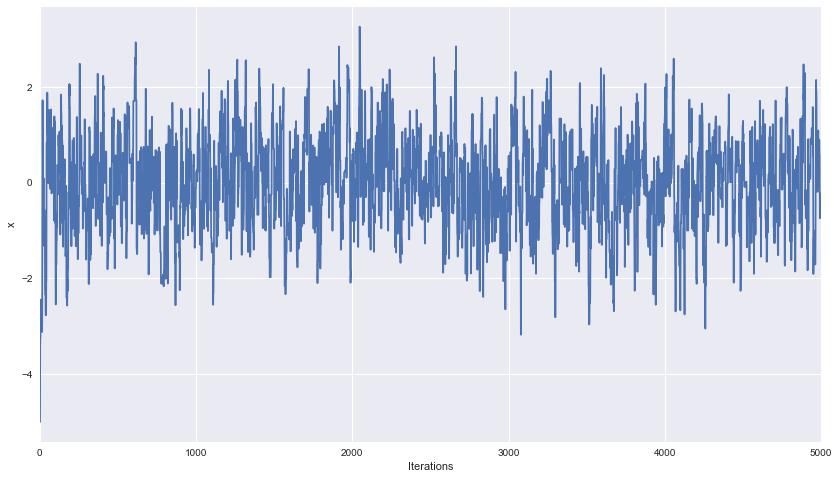

In [5]:
# plot the trace of the x parameter
fig = plt.figure(figsize=(14,8))
g = sns.tsplot(samples[:, 0])
plt.xlabel('Iterations')
plt.ylabel('x')
plt.savefig('snstrace.png')

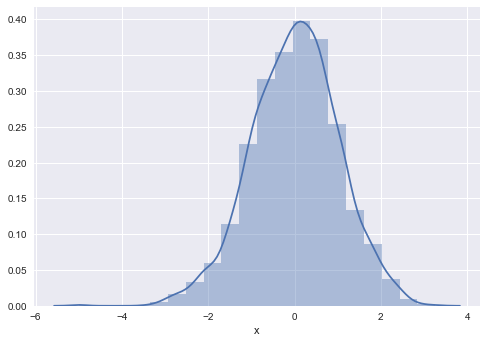

In [6]:
sns.distplot(samples[:,0], bins=20)
plt.xlabel('x')
plt.savefig('snsdistplot.png')

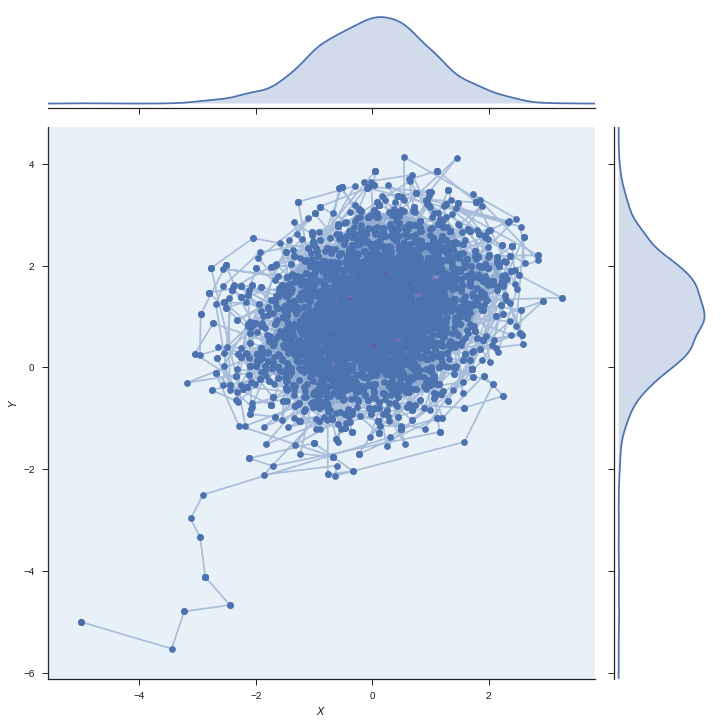

In [8]:
# style for seaborn
sns.set(style="ticks", color_codes=True)

# plot contour
g = (sns.JointGrid(samples[:, 0], samples[:, 1], size=10)
     .plot_joint(sns.kdeplot, n_levels=6, cmap="BuPu", shade=True, shade_lowest=True))

# plot marginals 
g = g.plot_marginals(sns.kdeplot, color="b", shade=True, shade_lowest=True)

# add scatter plot of data
g = g.plot_joint(plt.scatter, c="b", s=30, linewidth=1)
plt.plot(samples[:, 0], samples[:, 1], linestyle='-',  marker='o', alpha=0.4, )

# set axis labels
g.set_axis_labels("$X$", "$Y$")

# save the figure 
g.savefig('snsfinal.png')

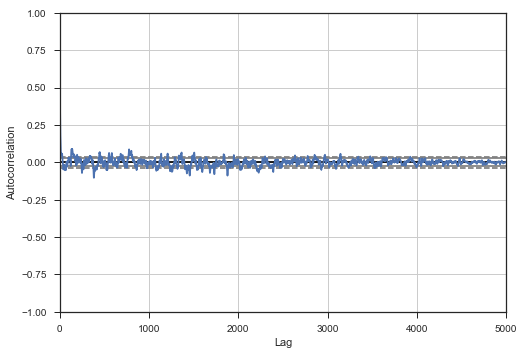

In [12]:
pandas.tools.plotting.autocorrelation_plot(samples[:, 0])
plt.savefig('autocorrelation.png')